# Automated ML for time series predicion

We used one of the dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, i.e. NYC taxi passengers dataset, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot. 

In [1]:
%load_ext autoreload
%autoreload 2

## 0. Helper function definations

In [2]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="timestamp", value_col="value", past_seq_len=1):
    # target column of dataframe is "value"
    # default past sequence length is 1
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# plot results of multi step forecasting
# plot at most five values for better view
# plot the predicted values and actual values (for the test data)
def plot_less_five_step_result(test_df, pred_df, dt_col="timestamp", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(min(pred_df.shape[1] - 1, 5))]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
    plot_color = ["g", "r", "c", "m", "y"]
    for i in range(len(value_cols)):
        pred_value = pred_df[value_cols[i]].values
        pred_dt = pred_df[dt_col].values + time_delta * i
        axs.plot(pred_dt, pred_value, color=plot_color[i], label='predicted values' + str(i))

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
# plot results of multi step forecasting
# plot result of multi step forecasting
# plot the predicted values and actual values (for the test data)
def plot_first_last_step_result(test_df, pred_df, dt_col="timestamp", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(pred_df.shape[1] - 1)]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
  
    pred_value_first = pred_df[value_cols[0]].values
    pred_dt_first = pred_df[dt_col].values
    axs.plot(pred_dt_first, pred_value_first, color="g", label='first predicted values')
 
    pred_value_last = pred_df[value_cols[-1]].values
    pred_dt_last = pred_df[dt_col].values + time_delta * (len(value_cols)-1)
    axs.plot(pred_dt_last, pred_value_last, color="r", label='last predicted values')

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

## 1. load data

In [5]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Now we download the dataset and load it into a pandas dataframe.
Run the script `$ANALYTICS_ZOO_HOME/dist/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh` to download the raw data

In [6]:
# load nyc taxi data
try:
    dataset_path = os.getenv("ANALYTICS_ZOO_HOME")+"/bin/data/NAB/nyc_taxi/nyc_taxi.csv"
    raw_df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

Below are some example records of the data

In [7]:
raw_df.head(5)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Convert string timestamp to TimeStamp

In [8]:
df = pd.DataFrame(pd.to_datetime(raw_df.timestamp))
df["value"] = raw_df["value"]
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


You can use train_val_test_split to split the whole dataset into train/val/test sets. There will be two columns in the output dataframe: "timestamp" and "value", where the data type of "timestamp" column is datetime64.

In [9]:
from zoo.chronos.autots.deprecated.preprocessing.utils import train_val_test_split
train_df, val_df, test_df = train_val_test_split(df, val_ratio=0.1, test_ratio=0.1)

In [10]:
train_df.describe()

,value
count,8256.000000
mean,15421.585514
std,6871.989592
min,1431.000000
25%,11040.000000
50%,17014.500000
75%,20032.250000
max,39197.000000


In [11]:
train_df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [12]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8256, 2)
The shape of val_df is (1032, 2)
The shape of test_df is (1032, 2)


No handles with labels found to put in legend.


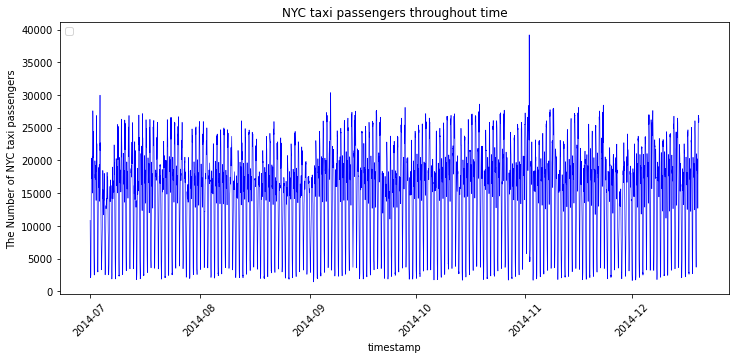

In [13]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['timestamp'], train_df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('timestamp')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

## 2. Train and validation

You can use analytices zoo automl to predict time series data by simply define a `TimeSequencePredictor`. 

We use feature tools to generate features from the given datetime. The generated features are \['HOUR', 'DAY', 'MONTH'. 'IS_AWAKE', 'IS_BUSY_HOURS'\]. Our feature space comprises these generated features as well as the original inputs such as \['datetime','value','extra_features'\].  

Currently, We use RNN to learn from 50 previous values, and predict just the 1 next value. You can specify the sequence length to predict while creating `TimeSequencePredictor` with arg: `future_seq_len`.

In [14]:
# build time sequence predictor
from zoo.chronos.autots.deprecated.regression.time_sequence_predictor import TimeSequencePredictor

# you need to specify the name of datetime column and target column
# The default names are "timestamp" and "value" respectively.
tsp = TimeSequencePredictor(name="nyc_taxi_1next",
                            logs_dir="~/zoo_automl_logs",
                            dt_col="timestamp",
                            target_col="value",
                            extra_features_col=None)

/home/junweid/intel_PR4/analytics-zoo/pyzoo/zoo/chronos/utils.py:27: DeprecationWarning: SmokeRecipe will be deprecated in future release. Please use `zoo.orca.automl.hp` instead.
  category=DeprecationWarning)
/home/junweid/intel_PR4/analytics-zoo/pyzoo/zoo/chronos/utils.py:27: DeprecationWarning: TimeSequencePredictor will be deprecated in future release. Please use `zoo.chronos.autots.AutoTSEstimator` instead.
  category=DeprecationWarning)


In [15]:
from zoo import init_spark_on_local
from zoo.ray import RayContext
sc = init_spark_on_local(cores=4)
ray_ctx = RayContext(sc=sc, object_store_memory="1g")
ray_ctx.init()

Current pyspark location is : /home/junweid/spark-2.4.3/spark-2.4.3-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/junweid/intel_PR4/analytics-zoo/zoo/target/analytics-zoo-bigdl_0.13.0-spark_2.4.6-0.12.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2021-09-21 23:17:59,169	INFO services.py:1174 -- View the Ray dashboard at http://10.239.44.67:8265


{'node_ip_address': '10.239.44.67', 'raylet_ip_address': '10.239.44.67', 'redis_address': '10.239.44.67:6379', 'object_store_address': '/tmp/ray/session_2021-09-21_23-17-58_641602_19027/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-09-21_23-17-58_641602_19027/sockets/raylet', 'webui_url': '10.239.44.67:8265', 'session_dir': '/tmp/ray/session_2021-09-21_23-17-58_641602_19027', 'metrics_export_port': 58304, 'node_id': '00ba52539dd4372e3fd22f973e6da38e309ecf6cad119aeb041e7813'}


{'node_ip_address': '10.239.44.67',
 'raylet_ip_address': '10.239.44.67',
 'redis_address': '10.239.44.67:6379',
 'object_store_address': '/tmp/ray/session_2021-09-21_23-17-58_641602_19027/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-09-21_23-17-58_641602_19027/sockets/raylet',
 'webui_url': '10.239.44.67:8265',
 'session_dir': '/tmp/ray/session_2021-09-21_23-17-58_641602_19027',
 'metrics_export_port': 58304,
 'node_id': '00ba52539dd4372e3fd22f973e6da38e309ecf6cad119aeb041e7813'}

In [16]:
%%time
from zoo.chronos.autots.deprecated.config.recipe import LSTMGridRandomRecipe
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, LSTMGridRandomRecipe, GridRandomRecipe and BayesRecipe.
look_back_single = 5
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=LSTMGridRandomRecipe(
                              num_rand_samples=1,
                              epochs=2,
                              look_back=look_back_single, 
                              batch_size=[64]))
print("Training completed.")

2021-09-21 23:20:33,694	INFO tune.py:450 -- Total run time: 153.84 seconds (153.78 seconds for the tuning loop).


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training completed.
CPU times: user 7.52 s, sys: 962 ms, total: 8.49 s
Wall time: 2min 34s


We provided a leaderboard visualization tool based on tensorboard. You can install tensorboard and run the following code to view the hparams tag in tensorboard. <br>
`logs_dir` is the log directory you set for your predictor(i.e. TimeSequencePredictor), in this case "/home/`username`/zoo_automl_logs", where `username` is your login username. `job_name` is your predictor name, which in this case is "nyc_taxi_1next". A typical interface is shown below

In [17]:
#%load_ext tensorboard
#%tensorboard --logdir <logs_dir>/<job_name>_leaderboard/

![jupyter](./vis_demo.PNG)

## 3. Test

In [18]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [19]:
pred_df.head(5)

,timestamp,value
0,2015-01-10 14:30:00,20743.201172
1,2015-01-10 15:00:00,21027.966797
2,2015-01-10 15:30:00,21666.734375
3,2015-01-10 16:00:00,21645.306641
4,2015-01-10 16:30:00,21514.960938


In [20]:
# prediction value start from look_back_single
test_df[look_back_single:look_back_single+5]

,timestamp,value
5,2015-01-10 14:30:00,22371
6,2015-01-10 15:00:00,23119
7,2015-01-10 15:30:00,23941
8,2015-01-10 16:00:00,22728
9,2015-01-10 16:30:00,20126


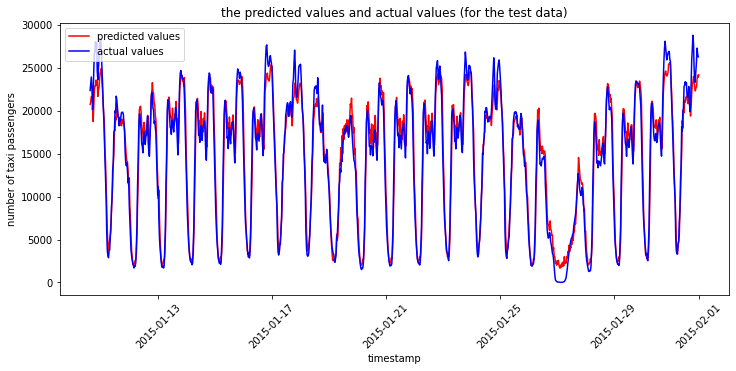

In [21]:
# plot the predicted values and actual values
plot_result(test_df, pred_df,past_seq_len=look_back_single)

In [22]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 2549850.449951971
Evaluate: the smape value is 7.037086757514169


## 4. save and restore

We provide save and restore interface to save the pipeline with the best trial for easily rebuilding.

In [23]:
# save the pipeline with best trial
pipeline.save("/tmp/saved_pipeline/my.ppl")

'/tmp/saved_pipeline/my.ppl'

In [24]:
from zoo.chronos.autots.deprecated.pipeline.time_sequence import load_ts_pipeline
new_pipeline = load_ts_pipeline("/tmp/saved_pipeline/my.ppl")

/home/junweid/intel_PR4/analytics-zoo/pyzoo/zoo/chronos/utils.py:27: DeprecationWarning: load_ts_pipeline will be deprecated in future release. Please use `zoo.chronos.autots.TSPipeline` instead.
  category=DeprecationWarning)


Restore pipeline from /tmp/saved_pipeline/my.ppl


In [25]:
# you can do predict and evaluate again
# we use test_df as input in order to compare results before and after restoration 
new_pred = new_pipeline.predict(test_df)

In [26]:
new_pred.head(5)

,timestamp,value
0,2015-01-10 14:30:00,20743.201172
1,2015-01-10 15:00:00,21027.966797
2,2015-01-10 15:30:00,21666.734375
3,2015-01-10 16:00:00,21645.306641
4,2015-01-10 16:30:00,21514.960938


In [27]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 2549850.449951971
Evaluate: the smape value is 7.037086757514169


## 5. continue training

We support continue training with incremental data using the best configuration searched and the trained model.

In [28]:
# review the initialization infomation if needed
new_pipeline.describe()

**** Initialization info ****
future_seq_len: 1
dt_col: timestamp
target_col: ['value']
extra_features_col: None
drop_missing: True



In [29]:
# Use val_df as incremental data
new_pipeline.fit(val_df,epoch_num=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1027 samples, validate on 1027 samples
Epoch 1/5
1027/1027 [==============================] - 1s 1ms/sample - loss: 0.0581 - mean_squared_error: 0.0581 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 2/5
1027/1027 [==============================] - 0s 383us/sample - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 3/5
1027/1027 [==============================] - 0s 412us/sample - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 4/5
1027/1027 [==============================] - 0s 406us/sample - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 5/5
1027/1027 [==============================] - 0s 410us/sample - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Fit done!


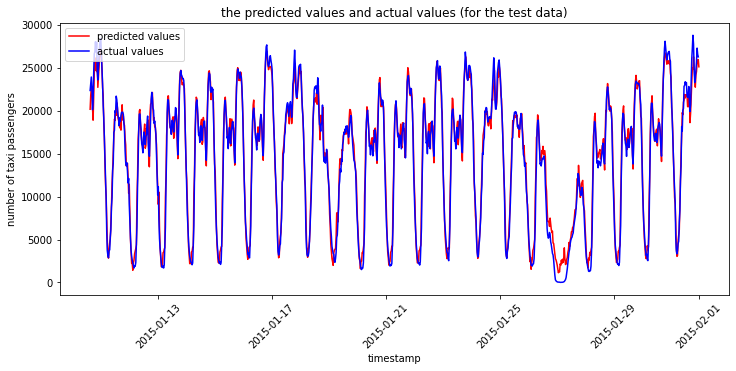

In [30]:
# predict results of test_df
new_pred_df = new_pipeline.predict(test_df)
plot_result(test_df, new_pred_df,past_seq_len = look_back_single)

In [31]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 1278033.6896545985
Evaluate: the smape value is 6.364918577933951


## 6. multi step forecasting 

You can do multi step forecasting by simply changing the `future_seq_len` option while creating a new `TimeSequencePredictor` object.

In [32]:
# build time sequence predictor
from zoo.chronos.autots.deprecated.regression.time_sequence_predictor import TimeSequencePredictor

# change future_seq_len into the step you want to forcast.
tsp = TimeSequencePredictor(name="nyc_taxi_10next",
                            logs_dir="~/zoo_automl_logs",
                            future_seq_len=5,
                            dt_col="timestamp",
                            target_col="value",
                            extra_features_col=None)

/home/junweid/intel_PR4/analytics-zoo/pyzoo/zoo/chronos/utils.py:27: DeprecationWarning: TimeSequencePredictor will be deprecated in future release. Please use `zoo.chronos.autots.AutoTSEstimator` instead.
  category=DeprecationWarning)


In [33]:
%%time
# you can specify the look back sequence length with a single number or a range of (min_len, max_len) in recipe.
look_back_multi = 10
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=LSTMGridRandomRecipe(
                              num_rand_samples=3,
                              epochs=2,
                              look_back=10,
                              training_iteration=look_back_multi,
                              batch_size=[64]))
print("Training completed.")

2021-09-21 23:30:21,444	INFO tune.py:450 -- Total run time: 580.27 seconds (580.24 seconds for the tuning loop).


Training completed.
CPU times: user 27.7 s, sys: 3.74 s, total: 31.5 s
Wall time: 9min 41s


In [34]:
# test
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [35]:
pred_df.head(5)

,timestamp,value_0,value_1,value_2,value_3,value_4
0,2015-01-10 17:00:00,22539.953125,23754.490234,24258.187500,23961.535156,22955.089844
1,2015-01-10 17:30:00,24739.871094,25224.955078,24759.046875,23544.388672,21739.417969
2,2015-01-10 18:00:00,25463.558594,25420.355469,24492.697266,23070.642578,21277.097656
3,2015-01-10 18:30:00,25984.853516,25414.490234,24184.707031,22821.626953,21382.382812
4,2015-01-10 19:00:00,25476.894531,24641.042969,23526.492188,22715.919922,22114.289062


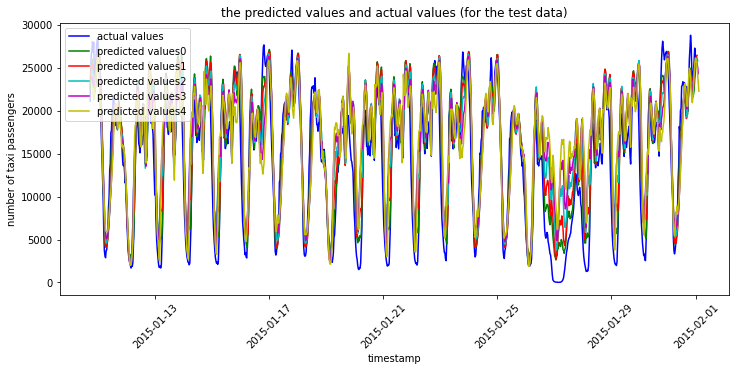

In [36]:
# plot multi step predicted values and actual values
# plot at most five step predict values for better view
plot_less_five_step_result(test_df, pred_df,past_seq_len=look_back_multi)

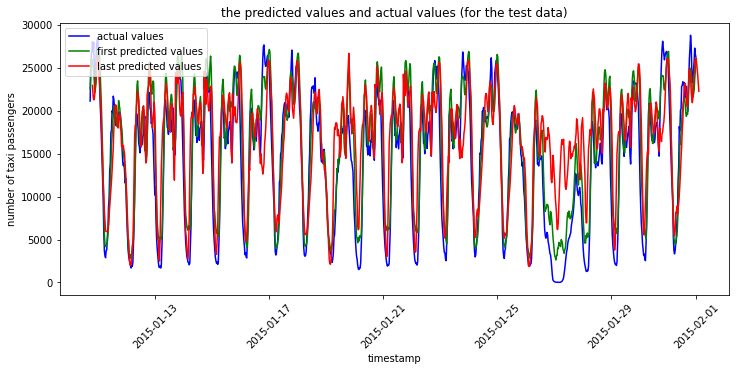

In [37]:
# plot only the first and the last step predict values and actual values
plot_first_last_step_result(test_df, pred_df, past_seq_len=look_back_multi)

In [38]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is [ 8778227.52881416 13544419.53852191 19099120.64595068 23357207.38805964
 26447425.63666327]
Evaluate: the smape value is [12.70421215 14.89848805 16.52275322 17.05756319 17.08576511]


In [39]:
ray_ctx.stop()